In [3]:
import os
import tensorflow as tf
from glob import glob
import cv2
import numpy as np
import pandas as pd
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.models import Model
import tensorflow.keras.backend as K
from keras.layers import Cropping2D
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Add, Activation, Lambda
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm import tqdm
import time
from sklearn.model_selection import train_test_split
import tensorflow.keras.layers as L

In [4]:
batch_size = 6
lr = 1e-3
epochs = 200
width = 256
height = 256

In [5]:
dataset_path = os.path.join("/kaggle/input/aeroscaapes/aeroscapes2000")
files_dir = os.path.join("files", "modified_uavid_dataset")
model_file = os.path.join(files_dir, "UnetModel.keras")
log_file = os.path.join(files_dir, "Log-Unet.csv")

# Function to create directory
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        
create_dir(files_dir)

In [6]:
def load_data(path):
    Images = sorted(glob(os.path.join(path, "JPEGImages", "*")))
    Labels = sorted(glob(os.path.join(path, "Visualizations", "*")))

    return (Images, Labels)

In [7]:
(Images, Labels) = load_data(dataset_path)

print(f"New Train: {len(Images)} - {len(Labels)}")

# First, split off 10% of the data for testing
train_val_images, test_x, train_val_labels, test_y = train_test_split(Images, Labels, test_size=0.1, random_state=42)

# Then, split the remaining 90% into 70% training and 20% validation (0.7 / 0.9 ≈ 0.78)
train_x, valid_x, train_y, valid_y = train_test_split(train_val_images, train_val_labels, test_size=0.22, random_state=42)

print(f"Training set: {len(train_x)} images")
print(f"Validation set: {len(valid_x)} images")
print(f"Test set: {len(test_x)} images")

# Now, train_x, train_y, valid_x, valid_y, test_x, test_y are ready for use.

New Train: 5563 - 5563
Training set: 3904 images
Validation set: 1102 images
Test set: 557 images


In [8]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (width, height))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

In [9]:
color_map = {
    (0, 0, 0): 0,            # Background
    (192, 128, 128): 1,      # Person
    (0, 128, 0): 2,          # Bike
    (128, 128, 128): 3,      # Car
    (128, 0, 0): 4,          # Drone
    (0, 0, 128): 5,          # Boat
    (192, 0, 128): 6,        # Animal
    (192, 0, 0): 7,          # Obstacle
    (192, 128, 0): 8,        # Construction
    (0, 64, 0): 9,           # Vegetation
    (128, 128, 0): 10,       # Road
    (0, 128, 128): 11,       # Sky
}

def read_mask(path):
    path = path.decode()
    mask = cv2.imread(path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask = cv2.resize(mask, (width, height), interpolation=cv2.INTER_NEAREST)
    class_indices = np.zeros((height, width), dtype=np.uint8)
    for rgb, idx in color_map.items():
        class_indices[(mask == rgb).all(axis=-1)] = idx
    
    # Convert to one-hot encoding
    one_hot_mask = tf.one_hot(class_indices, depth=12)  # 8 classes as per your color_map
    return one_hot_mask.numpy()

In [10]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y
    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([height, width, 3])
    y.set_shape([height, width, 12])  # 8 classes
    return x, y

In [11]:
def tf_dataset(x, y, batch=6):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [12]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)
test_dataset = tf_dataset(test_x, test_y, batch=batch_size)

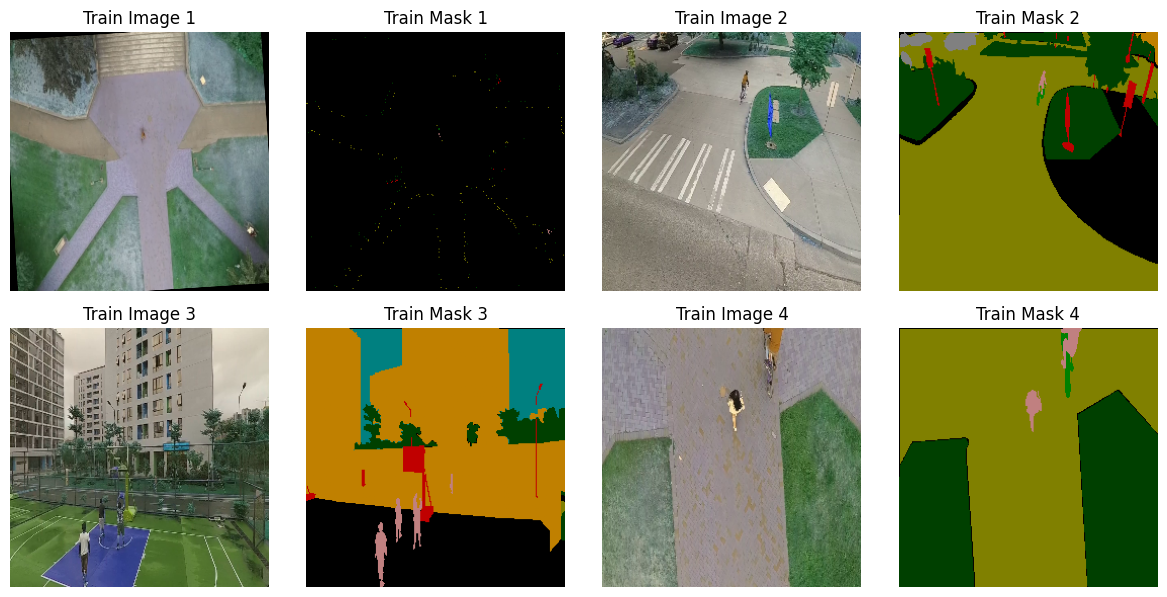

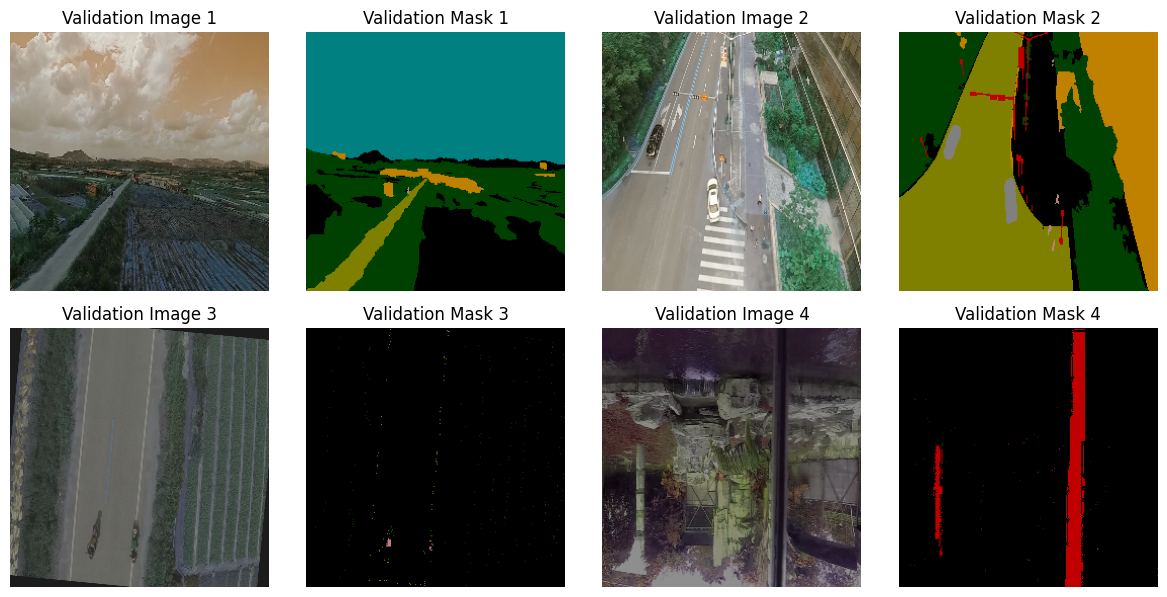

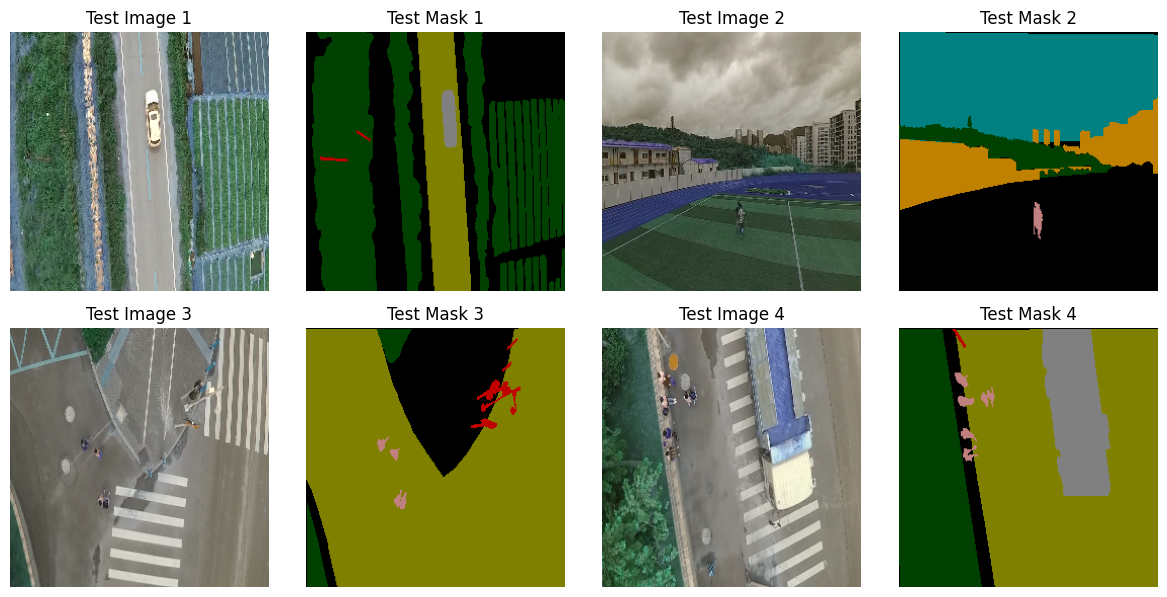

In [13]:
# Create a custom color map based on the color_map dictionary
color_map_values = list(color_map.keys())
color_map_rgb = np.array(color_map_values) / 255.0  # Normalize to 0-1 range for matplotlib

def plot_samples_with_labels(dataset, title):
    plt.figure(figsize=(12, 12))
    for i, (images, masks) in enumerate(dataset.take(1)):  # Take a single batch
        for j in range(4):  # Loop over first four images
            # Plot the image
            plt.subplot(4, 4, j*2 + 1)
            plt.imshow(images[j].numpy())
            plt.axis("off")
            plt.title(f"{['Train', 'Validation', 'Test'][title]} Image {j+1}")

            # Convert one-hot mask back to class indices
            class_indices = np.argmax(masks[j].numpy(), axis=-1)

            # Convert class indices to RGB colors
            mask_rgb = np.zeros((height, width, 3), dtype=np.float32)
            for idx, color in enumerate(color_map_rgb):
                mask_rgb[class_indices == idx] = color

            # Plot the label mask
            plt.subplot(4, 4, j*2 + 2)
            plt.imshow(mask_rgb)
            plt.axis("off")
            plt.title(f"{['Train', 'Validation', 'Test'][title]} Mask {j+1}")
    
    plt.tight_layout()
    plt.show()


# Plot the images and corresponding label masks for each dataset
plot_samples_with_labels(train_dataset, title=0)   # Train images and masks
plot_samples_with_labels(valid_dataset, title=1)   # Validation images and masks
plot_samples_with_labels(test_dataset, title=2)    # Test images and masks

In [14]:
from tensorflow.keras.layers import Layer
@tf.keras.utils.register_keras_serializable(package='Custom', name='SplitWeights')
class SplitWeights(Layer):
    def call(self, inputs):
        avg_weight, max_weight = tf.split(inputs, num_or_size_splits=2, axis=1)
        return avg_weight, max_weight
        
def dynamic_channel_attention(input_tensor, ratio=16):
    channel = input_tensor.shape[-1]
    
    # Shared layers
    shared_dense_1 = L.Dense(channel // ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_dense_2 = L.Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    
    # Average pooling branch
    avg_pool = L.GlobalAveragePooling2D()(input_tensor)
    avg_pool = L.Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_dense_1(avg_pool)
    avg_pool = shared_dense_2(avg_pool)
    
    # Max pooling branch
    max_pool = L.GlobalMaxPooling2D()(input_tensor)
    max_pool = L.Reshape((1, 1, channel))(max_pool)
    max_pool = shared_dense_1(max_pool)
    max_pool = shared_dense_2(max_pool)
    
    # Learnable pooling weights
    pooling_weights = L.Dense(2, activation='softmax')(L.Flatten()(input_tensor))
    
    # Use custom SplitWeights layer
    avg_weight, max_weight = SplitWeights()(pooling_weights)
    
    # Weighted combination of pooling features
    weighted_avg_pool = L.Multiply()([avg_pool, L.Reshape((1, 1, 1))(avg_weight)])
    weighted_max_pool = L.Multiply()([max_pool, L.Reshape((1, 1, 1))(max_weight)])
    combined_pool = L.Add()([weighted_avg_pool, weighted_max_pool])
    
    # Activation
    cbam_feature = L.Activation('sigmoid')(combined_pool)
    return L.Multiply()([input_tensor, cbam_feature])

def multi_scale_spatial_attention(input_tensor):
    # Average pool across channels
    avg_pool = L.GlobalAveragePooling2D(keepdims=True)(input_tensor)
    
    # Max pool across channels
    max_pool = L.GlobalMaxPooling2D(keepdims=True)(input_tensor)
    
    # Concatenate pooled features
    concat = L.Concatenate(axis=-1)([avg_pool, max_pool])

    # Multi-scale convolutional layers
    conv_3x3 = L.Conv2D(1, kernel_size=3, dilation_rate=1, padding='same',
                        activation=None, kernel_initializer='he_normal')(concat)
    conv_5x5 = L.Conv2D(1, kernel_size=5, dilation_rate=1, padding='same',
                        activation=None, kernel_initializer='he_normal')(concat)
    conv_dilated_3 = L.Conv2D(1, kernel_size=3, dilation_rate=3, padding='same',
                              activation=None, kernel_initializer='he_normal')(concat)
    
    # Combine multi-scale features
    combined = L.Add()([conv_3x3, conv_5x5, conv_dilated_3])
    combined = L.Activation('sigmoid')(combined)

    # Apply the spatial attention map
    return L.Multiply()([input_tensor, combined])

def cbam_module(input_tensor, ratio=16):
    x = dynamic_channel_attention(input_tensor, ratio)
    x = multi_scale_spatial_attention(x)
    return x

In [15]:
def conv_block(x, num_filters, act=True):
    x = L.Conv2D(num_filters, kernel_size=3, padding="same")(x)

    if act == True:
        x = L.BatchNormalization()(x)
        x = L.Activation("relu")(x)

    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    x = conv_block(x, num_filters)
    x = cbam_module(x)
    p = L.MaxPool2D((2, 2))(x)
    return x, p

def unet3plus(input_shape, num_classes=12):
    """ Inputs """
    inputs = L.Input(input_shape, name="input_layer")

    """ Encoder """
    e1, p1 = encoder_block(inputs, 64)
    e2, p2 = encoder_block(p1, 128)
    e3, p3 = encoder_block(p2, 256)
    e4, p4 = encoder_block(p3, 512)

    """ Bottleneck """
    e5 = conv_block(p4, 1024)
    e5 = cbam_module(e5)
    e5 = conv_block(e5, 1024)

    """ Decoder 4 """
    e1_d4 = L.MaxPool2D((8, 8))(e1)
    e1_d4 = conv_block(e1_d4, 64)

    e2_d4 = L.MaxPool2D((4, 4))(e2)
    e2_d4 = conv_block(e2_d4, 64)

    e3_d4 = L.MaxPool2D((2, 2))(e3)
    e3_d4 = conv_block(e3_d4, 64)

    e4_d4 = conv_block(e4, 64)

    e5_d4 = L.UpSampling2D((2, 2), interpolation="bilinear")(e5)
    e5_d4 = conv_block(e5_d4, 64)

    d4 = L.Concatenate()([e1_d4, e2_d4, e3_d4, e4_d4, e5_d4])
    d4 = cbam_module(d4)
    d4 = conv_block(d4, 64*5)

    """ Decoder 3 """ #8000F8
    e1_d3 = L.MaxPool2D((4, 4))(e1)
    e1_d3 = conv_block(e1_d3, 64)

    e2_d3 = L.MaxPool2D((2, 2))(e2)
    e2_d3 = conv_block(e2_d3, 64)

    e3_d3 = conv_block(e3, 64)

    d4_d3 = L.UpSampling2D((2, 2), interpolation="bilinear")(d4)
    d4_d3 = conv_block(d4_d3, 64)

    e5_d3 = L.UpSampling2D((4, 4), interpolation="bilinear")(e5)
    e5_d3 = conv_block(e5_d3, 64)

    d3 = L.Concatenate()([e1_d3, e2_d3, e3_d3, d4_d3, e5_d3])
    d3 = cbam_module(d3)
    d3 = conv_block(d3, 64*5)

    """ Decoder 2 """
    e1_d2 = L.MaxPool2D((2, 2))(e1)
    e1_d2 = conv_block(e1_d2, 64)

    e2_d2 = conv_block(e2, 64)

    d3_d2 = L.UpSampling2D((2, 2), interpolation="bilinear")(d3)
    d3_d2 = conv_block(d3_d2, 64)

    d4_d2 = L.UpSampling2D((4, 4), interpolation="bilinear")(d4)
    d4_d2 = conv_block(d4_d2, 64)

    e5_d2 = L.UpSampling2D((8, 8), interpolation="bilinear")(e5)
    e5_d2 = conv_block(e5_d2, 64)

    d2 = L.Concatenate()([e1_d2, e2_d2, d3_d2, d4_d2, e5_d2])
    d2 = cbam_module(d2)
    d2 = conv_block(d2, 64*5)

    """ Decoder 1 """
    e1_d1 = conv_block(e1, 64)

    d2_d1 = L.UpSampling2D((2, 2), interpolation="bilinear")(d2)
    d2_d1 = conv_block(d2_d1, 64)

    d3_d1 = L.UpSampling2D((4, 4), interpolation="bilinear")(d3)
    d3_d1 = conv_block(d3_d1, 64)

    d4_d1 = L.UpSampling2D((8, 8), interpolation="bilinear")(d4)
    d4_d1 = conv_block(d4_d1, 64)

    e5_d1 = L.UpSampling2D((16, 16), interpolation="bilinear")(e5)
    e5_d1 = conv_block(e5_d1, 64)

    d1 = L.Concatenate()([e1_d1, d2_d1, d3_d1, d4_d1, e5_d1])
    d1 = cbam_module(d1)
    d1 = conv_block(d1, 64*5)

    """ Output """
    y1 = L.Conv2D(num_classes, kernel_size=3, padding="same")(d1)
    y1 = L.Activation("softmax")(y1)
    outputs = [y1]

    model = tf.keras.Model(inputs, outputs)
    return model


In [16]:
input_shape = (256, 256, 3)
model = unet3plus(input_shape, 12)

In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 64)             │              0 │ activation_1[0][0]     │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 4194304)        │              0 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d      │ (None, 64)             │              0 │ activation_1[0][0]     │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 64)       │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2)              │      8,388,610 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 1, 64)       │              0 │ global_max_pooling2d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1, 1, 4)        │            260 │ reshape[0][0],         │
│                           │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ split_weights             │ [(None, 1), (None, 1)] │              0 │ dense_2[0][0]          │
│ (SplitWeights)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1, 1, 64)       │            320 │ dense[0][0],           │
│                           │                        │                │ dense[1][0]            │
├──────────────────────

 Total params: 99,485,061 (379.51 MB)

 Trainable params: 99,472,005 (379.46 MB)

 Non-trainable params: 13,056 (51.00 KB)

In [18]:
alpha = 0.25
gamma = 2.0

# Compile the model with focal loss
opt = tf.keras.optimizers.Adam(lr)
model.compile(
    loss=tf.keras.losses.CategoricalFocalCrossentropy(
        alpha=alpha,
        gamma=gamma,
        from_logits=False  # Since we have softmax activation in the final layer
    ),
    optimizer=opt,
    metrics=['categorical_accuracy']
)

In [19]:
callbacks = [
    ModelCheckpoint(model_file, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", mode='auto', factor=0.1, patience=4),
    CSVLogger(log_file),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
]

In [ ]:
model = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/200
651/651 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.5800 - loss: 0.1456
Epoch 1: val_loss improved from inf to 0.15488, saving model to files/modified_uavid_dataset/UnetModel.keras
651/651 ━━━━━━━━━━━━━━━━━━━━ 1587s 2s/step - categorical_accuracy: 0.5801 - loss: 0.1455 - val_categorical_accuracy: 0.5411 - val_loss: 0.1549 - learning_rate: 0.0010
Epoch 2/200
651/651 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7008 - loss: 0.0803
Epoch 2: val_loss improved from 0.15488 to 0.05401, saving model to files/modified_uavid_dataset/UnetModel.keras
651/651 ━━━━━━━━━━━━━━━━━━━━ 1213s 2s/step - categorical_accuracy: 0.7009 - loss: 0.0803 - val_categorical_accuracy: 0.8142 - val_loss: 0.0540 - learning_rate: 0.0010
Epoch 3/200
651/651 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7715 - loss: 0.0631
Epoch 3: val_loss did not improve from 0.05401
651/651 ━━━━━━━━━━━━━━━━━━━━ 1203s 2s/step - categorical_accuracy: 0.7715 - loss: 0.0631 - val_categori

In [ ]:
save_path = os.path.join("Prediction", "modified_uavid_dataset")
model_file = "/kaggle/working/files/modified_uavid_dataset/UnetModel.keras"
create_dir(save_path)

In [ ]:
model = tf.keras.models.load_model(model_file)

In [ ]:
import pandas as pd
# Load the CSV log file
log_file = os.path.join(files_dir, "Log-Unet.csv")
log_data = pd.read_csv(log_file)
# Check available columns in the CSV
print(log_data.columns)

# Plot Training and Validation Loss
plt.figure(figsize=(6, 6))
plt.plot(log_data['loss'], label='Training Loss')
plt.plot(log_data['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Save the Loss plot
loss_plot_file_path = os.path.join(files_dir, 'training_validation_loss.png')
plt.savefig(loss_plot_file_path)
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(6, 6))
plt.plot(log_data['categorical_accuracy'], label='Training Accuracy')
plt.plot(log_data['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Save the Accuracy plot
accuracy_plot_file_path = os.path.join(files_dir, 'training_validation_accuracy.png')
plt.savefig(accuracy_plot_file_path)  # Close the figure to free memory
plt.show()

In [ ]:
class_to_rgb = {v: k for k, v in color_map.items()}

class_colors = {k: tuple(v/255.0 for v in rgb) for k, rgb in class_to_rgb.items()}
colors = np.array([class_colors[i] for i in sorted(class_colors.keys())])
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(boundaries=np.arange(len(class_colors)+1) - 0.5, ncolors=len(class_colors))

def map_class_to_rgb(class_mask):
    rgb_mask = np.zeros((class_mask.shape[0], class_mask.shape[1], 3), dtype=np.uint8)
    for class_index, rgb in class_to_rgb.items():
        rgb_mask[class_mask == class_index] = rgb
    return rgb_mask


plt.figure(figsize=(15, 10))  

batch = next(iter(test_dataset)) 
batch_x, batch_y = batch

num_images = batch_x.shape[0]

for i in range(num_images):

    image = batch_x[i].numpy()
    mask = batch_y[i].numpy()


    prediction = model.predict(np.expand_dims(image, axis=0))[0]  
    predicted_class_indices = np.argmax(prediction, axis=-1) 

    predicted_mask_rgb = map_class_to_rgb(predicted_class_indices)

    original_label_path = test_y[i] 
    original_label = cv2.imread(original_label_path, cv2.IMREAD_COLOR)
    original_label = cv2.cvtColor(original_label, cv2.COLOR_BGR2RGB)
    original_label = cv2.resize(original_label, (width, height)) / 255.0

    plt.subplot(num_images, 3, 3*i + 1)
    plt.imshow(image)
    plt.title(f"Input Image {i+1}")
    plt.axis("off")

    plt.subplot(num_images, 3, 3*i + 2)
    plt.imshow(original_label)
    plt.title(f"Original Label {i+1}")
    plt.axis("off")

    plt.subplot(num_images, 3, 3*i + 3)
    plt.imshow(predicted_mask_rgb)
    plt.title(f"Predicted Mask {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
time_taken = []
for x in tqdm(test_x):
    
    seq_folder = x.split("/")[-3]
    image_name = x.split("/")[-1]
    
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (width, height))
    x = x / 255.0
    x = np.expand_dims(x, axis=0)

    start_time = time.time()
    p = model.predict(x)[0] 
    total_time = time.time() - start_time
    time_taken.append(total_time)

    p_class_indices = np.argmax(p, axis=-1)  
    
    p_rgb = np.zeros((p_class_indices.shape[0], p_class_indices.shape[1], 3), dtype=np.uint8)
    
    for rgb, idx in color_map.items():
        p_rgb[p_class_indices == idx] = rgb 
    
    p_rgb = cv2.cvtColor(p_rgb, cv2.COLOR_RGB2BGR)

    save_path_with_name = os.path.join(save_path, f"{seq_folder}_{image_name}")
    cv2.imwrite(save_path_with_name, p_rgb)

In [ ]:
!zip -r aeroCBAMunet3plus.zip /kaggle/working
from IPython.display import FileLink
FileLink(r'aeroCBAMunet3plus.zip')

In [ ]:
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

# Email configuration
smtp_server = 'smtp.gmail.com'
smtp_port = 587
sender_email = 'anirban177133@gmail.com'
receiver_emails = ['anirban177133@protonmail.com', 'piyushroy192002@gmail.com']  # List of recipients
app_password = 'rtru xazb ldqz gzmu'  # Use the app password generated by Google

# Create the email message
message = MIMEMultipart()
message['From'] = sender_email
message['To'] = ', '.join(receiver_emails)  # Join multiple emails with commas
message['Subject'] = 'Kaggle: Unet3+CBAM Notification from your notebook'

# Email body
body = 'Hello, Unet3+CBAM has been trained succesfully.'
message.attach(MIMEText(body, 'plain'))

# Sending the email
try:
    server = smtplib.SMTP(smtp_server, smtp_port)
    server.starttls()  # Secure the connection
    server.login(sender_email, app_password)
    text = message.as_string()
    server.sendmail(sender_email, receiver_emails, text)  # Send to multiple recipients
    server.quit()

    print("Email sent successfully!")
except Exception as e:
    print(f"Error: {e}")